In [157]:
import os
import librosa
import _pickle as cPickle
from scipy.io.wavfile import read
from pathlib import Path
import warnings
import numpy as np
from sklearn import preprocessing
import python_speech_features as mfcc
from sklearn import metrics
from keras.utils import to_categorical

In [158]:
train_file ="C:\\Users\\B43E\\python\\py\\data\\f_list\\wav_list_train.txt"    
test_file ="C:\\Users\\B43E\\python\\py\\data\\f_list\\wav_list_test.txt" 
def calculate_delta(array):
    """Calculate and returns the delta of given feature vector matrix"""

    rows,cols = array.shape
    deltas = np.zeros((rows,20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
                first = 0
            else:
                first = i-j
            if i+j > rows -1:
                second = rows -1
            else:
                second = i+j
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

def extract_features(audio,rate):
    """extract 20 dim mfcc features from an audio, performs CMS and combines 
    delta to make it 40 dim feature vector"""    
    
    mfcc_feat = mfcc.mfcc(audio,rate, 0.025, 0.01,20,appendEnergy = True)
    
    mfcc_feat = preprocessing.scale(mfcc_feat)
    delta = calculate_delta(mfcc_feat)
    combined = np.hstack((mfcc_feat,delta)) 
    return combined
def get_features(file_path): 
    file_paths = open(file_path,'r')
    features_normalize = []
    total_feature = []
    features = np.asarray(())
    for path in file_paths:    
        path = path.strip()
        file_name=os.path.basename(path)
        audio, sr1 = librosa.load(path, sr=44100)
        data=librosa.resample(audio, sr1, 16000)
        vector   = extract_features(data,16000)
        if features.size == 0:
            features = vector
       
        else:
            features = np.vstack((features, vector)) 

        total_feature.append(features)
    return total_feature

In [159]:
def extract_label(file_path): 
    file_paths = open(file_path,'r')
    features_normalize = []
    total_feature = []
    labels = []
    features = np.asarray(())
    for path in file_paths:    
        path = path.strip()
        file_name=os.path.basename(path)
        audio, sr1 = librosa.load(path, sr=44100)
        data=librosa.resample(audio, sr1, 16000)
        vector   = extract_features(data,16000)

        if features.size == 0:
            features = vector

        
        else:
            features = np.vstack((features, vector))


        file_name=os.path.basename(path)

        split_filename=file_name.split('_')

        molecule_name=split_filename[0]

        for r in range(features.shape[0]):

            labels.append(molecule_name)
       
    return labels

In [160]:

# Extract features from the training data 
extracted_features_train = get_features(train_file) 
final_features_train = np.vstack(extracted_features_train)
# Extract features from the testing data 
extracted_features_test = get_features(test_file) 
final_features_test = np.vstack(extracted_features_test) 
# Extract labels from the training data 
train_label_value = extract_label(train_file)
train_final_label = np.array(train_label_value)
# Extract labels from the testing data 
test_label_value = extract_label(test_file)
test_final_label = np.array(test_label_value)
#print(test_final_label)
#print(test_final_label.shape)
x_train = final_features_train
x_test = final_features_test
#print(x_train)
#print(x_test)
y_train = train_final_label 
y_test =  test_final_label
#print(y_train)
#print(y_test)


In [161]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test  = label_encoder.fit_transform(y_test)
#print(y_train)
#print(y_test)
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)
#print(y_train_hot)
#print(y_test_hot)

In [168]:
import keras
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(16, input_dim=40,activation='sigmoid'))
model.add(Dense(12, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy']) 
history=model.fit(x_train, y_train_hot, batch_size=100, epochs=1000, verbose=1, validation_data=(x_test, y_test_hot))

Train on 36817 samples, validate on 36817 samples
Epoch 1/1000
36817/36817 [==============================] - 2s 56us/step - loss: 0.7221 - accuracy: 0.5500 - val_loss: 0.6730 - val_accuracy: 0.6002
Epoch 2/1000
36817/36817 [==============================] - 2s 46us/step - loss: 0.6730 - accuracy: 0.6002 - val_loss: 0.6726 - val_accuracy: 0.6002
Epoch 3/1000
36817/36817 [==============================] - 2s 50us/step - loss: 0.6727 - accuracy: 0.6002 - val_loss: 0.6724 - val_accuracy: 0.6002
Epoch 4/1000
36817/36817 [==============================] - 2s 48us/step - loss: 0.6715 - accuracy: 0.6002 - val_loss: 0.6708 - val_accuracy: 0.6002
Epoch 5/1000
36817/36817 [==============================] - 2s 47us/step - loss: 0.6691 - accuracy: 0.6002 - val_loss: 0.6672 - val_accuracy: 0.6002
Epoch 6/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.6640 - accuracy: 0.6002 - val_loss: 0.6602 - val_accuracy: 0.6002
Epoch 7/1000
36817/36817 [==============================

36817/36817 [==============================] - 2s 50us/step - loss: 0.5739 - accuracy: 0.5973 - val_loss: 0.5720 - val_accuracy: 0.6001
Epoch 56/1000
36817/36817 [==============================] - 2s 44us/step - loss: 0.5734 - accuracy: 0.5996 - val_loss: 0.5724 - val_accuracy: 0.6000
Epoch 57/1000
36817/36817 [==============================] - 2s 42us/step - loss: 0.5732 - accuracy: 0.5981 - val_loss: 0.5734 - val_accuracy: 0.5999
Epoch 58/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.5734 - accuracy: 0.5980 - val_loss: 0.5741 - val_accuracy: 0.6002
Epoch 59/1000
36817/36817 [==============================] - 2s 49us/step - loss: 0.5732 - accuracy: 0.5970 - val_loss: 0.5732 - val_accuracy: 0.5999
Epoch 60/1000
36817/36817 [==============================] - 2s 44us/step - loss: 0.5729 - accuracy: 0.5988 - val_loss: 0.5755 - val_accuracy: 0.6002
Epoch 61/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.5729 - accuracy: 0.5940 - val_

36817/36817 [==============================] - 2s 60us/step - loss: 0.5675 - accuracy: 0.5986 - val_loss: 0.5663 - val_accuracy: 0.6001
Epoch 110/1000
36817/36817 [==============================] - 2s 48us/step - loss: 0.5676 - accuracy: 0.5971 - val_loss: 0.5676 - val_accuracy: 0.6001
Epoch 111/1000
36817/36817 [==============================] - 2s 48us/step - loss: 0.5676 - accuracy: 0.5981 - val_loss: 0.5660 - val_accuracy: 0.6000
Epoch 112/1000
36817/36817 [==============================] - 2s 50us/step - loss: 0.5673 - accuracy: 0.6003 - val_loss: 0.5663 - val_accuracy: 0.6002
Epoch 113/1000
36817/36817 [==============================] - 2s 44us/step - loss: 0.5673 - accuracy: 0.5998 - val_loss: 0.5676 - val_accuracy: 0.6002
Epoch 114/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.5675 - accuracy: 0.5959 - val_loss: 0.5666 - val_accuracy: 0.6000
Epoch 115/1000
36817/36817 [==============================] - 2s 42us/step - loss: 0.5673 - accuracy: 0.5976 

36817/36817 [==============================] - 2s 47us/step - loss: 0.5650 - accuracy: 0.5968 - val_loss: 0.5638 - val_accuracy: 0.6001
Epoch 164/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.5651 - accuracy: 0.5995 - val_loss: 0.5641 - val_accuracy: 0.6002
Epoch 165/1000
36817/36817 [==============================] - 2s 42us/step - loss: 0.5650 - accuracy: 0.5962 - val_loss: 0.5638 - val_accuracy: 0.6002
Epoch 166/1000
36817/36817 [==============================] - 2s 48us/step - loss: 0.5648 - accuracy: 0.6016 - val_loss: 0.5648 - val_accuracy: 0.6000
Epoch 167/1000
36817/36817 [==============================] - 2s 53us/step - loss: 0.5649 - accuracy: 0.5962 - val_loss: 0.5636 - val_accuracy: 0.6001
Epoch 168/1000
36817/36817 [==============================] - 2s 42us/step - loss: 0.5647 - accuracy: 0.5994 - val_loss: 0.5638 - val_accuracy: 0.6000
Epoch 169/1000
36817/36817 [==============================] - 2s 42us/step - loss: 0.5647 - accuracy: 0.5994 

36817/36817 [==============================] - 2s 44us/step - loss: 0.5630 - accuracy: 0.5974 - val_loss: 0.5620 - val_accuracy: 0.6002
Epoch 218/1000
36817/36817 [==============================] - 2s 42us/step - loss: 0.5630 - accuracy: 0.5962 - val_loss: 0.5618 - val_accuracy: 0.6001
Epoch 219/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.5629 - accuracy: 0.5993 - val_loss: 0.5635 - val_accuracy: 0.6000
Epoch 220/1000
36817/36817 [==============================] - 2s 46us/step - loss: 0.5629 - accuracy: 0.5988 - val_loss: 0.5620 - val_accuracy: 0.6002
Epoch 221/1000
36817/36817 [==============================] - 2s 46us/step - loss: 0.5627 - accuracy: 0.6011 - val_loss: 0.5618 - val_accuracy: 0.6002
Epoch 222/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.5628 - accuracy: 0.5980 - val_loss: 0.5630 - val_accuracy: 0.6000
Epoch 223/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.5627 - accuracy: 0.6008 

36817/36817 [==============================] - 2s 46us/step - loss: 0.5613 - accuracy: 0.6005 - val_loss: 0.5604 - val_accuracy: 0.6002
Epoch 272/1000
36817/36817 [==============================] - 2s 52us/step - loss: 0.5614 - accuracy: 0.5974 - val_loss: 0.5611 - val_accuracy: 0.6000
Epoch 273/1000
36817/36817 [==============================] - 2s 50us/step - loss: 0.5612 - accuracy: 0.5988 - val_loss: 0.5608 - val_accuracy: 0.6002
Epoch 274/1000
36817/36817 [==============================] - 2s 46us/step - loss: 0.5613 - accuracy: 0.5961 - val_loss: 0.5605 - val_accuracy: 0.6002
Epoch 275/1000
36817/36817 [==============================] - 2s 47us/step - loss: 0.5612 - accuracy: 0.5982 - val_loss: 0.5610 - val_accuracy: 0.6002
Epoch 276/1000
36817/36817 [==============================] - 2s 52us/step - loss: 0.5613 - accuracy: 0.5952 - val_loss: 0.5603 - val_accuracy: 0.6002
Epoch 277/1000
36817/36817 [==============================] - 2s 46us/step - loss: 0.5612 - accuracy: 0.5971 

36817/36817 [==============================] - 2s 43us/step - loss: 0.5601 - accuracy: 0.5987 - val_loss: 0.5596 - val_accuracy: 0.6002
Epoch 326/1000
36817/36817 [==============================] - 2s 45us/step - loss: 0.5601 - accuracy: 0.5965 - val_loss: 0.5595 - val_accuracy: 0.6002
Epoch 327/1000
36817/36817 [==============================] - 2s 50us/step - loss: 0.5601 - accuracy: 0.6007 - val_loss: 0.5591 - val_accuracy: 0.6002
Epoch 328/1000
36817/36817 [==============================] - 2s 44us/step - loss: 0.5601 - accuracy: 0.5993 - val_loss: 0.5600 - val_accuracy: 0.6001
Epoch 329/1000
36817/36817 [==============================] - 2s 49us/step - loss: 0.5601 - accuracy: 0.5978 - val_loss: 0.5591 - val_accuracy: 0.6002
Epoch 330/1000
36817/36817 [==============================] - 2s 48us/step - loss: 0.5601 - accuracy: 0.5979 - val_loss: 0.5591 - val_accuracy: 0.6002
Epoch 331/1000
36817/36817 [==============================] - 2s 48us/step - loss: 0.5599 - accuracy: 0.6040 

36817/36817 [==============================] - 2s 47us/step - loss: 0.5592 - accuracy: 0.5973 - val_loss: 0.5588 - val_accuracy: 0.6001
Epoch 380/1000
36817/36817 [==============================] - 2s 55us/step - loss: 0.5592 - accuracy: 0.5959 - val_loss: 0.5585 - val_accuracy: 0.6002
Epoch 381/1000
36817/36817 [==============================] - 2s 45us/step - loss: 0.5591 - accuracy: 0.5974 - val_loss: 0.5586 - val_accuracy: 0.6002
Epoch 382/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.5593 - accuracy: 0.5965 - val_loss: 0.5589 - val_accuracy: 0.6002
Epoch 383/1000
36817/36817 [==============================] - 2s 44us/step - loss: 0.5591 - accuracy: 0.5999 - val_loss: 0.5584 - val_accuracy: 0.6002
Epoch 384/1000
36817/36817 [==============================] - 2s 50us/step - loss: 0.5592 - accuracy: 0.5974 - val_loss: 0.5584 - val_accuracy: 0.6002
Epoch 385/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.5592 - accuracy: 0.5995 

36817/36817 [==============================] - 2s 44us/step - loss: 0.5586 - accuracy: 0.5998 - val_loss: 0.5582 - val_accuracy: 0.6001
Epoch 434/1000
36817/36817 [==============================] - 2s 52us/step - loss: 0.5584 - accuracy: 0.6012 - val_loss: 0.5585 - val_accuracy: 0.6002
Epoch 435/1000
36817/36817 [==============================] - 2s 47us/step - loss: 0.5585 - accuracy: 0.5978 - val_loss: 0.5579 - val_accuracy: 0.6002
Epoch 436/1000
36817/36817 [==============================] - 2s 46us/step - loss: 0.5587 - accuracy: 0.5974 - val_loss: 0.5578 - val_accuracy: 0.6002
Epoch 437/1000
36817/36817 [==============================] - 2s 47us/step - loss: 0.5586 - accuracy: 0.5962 - val_loss: 0.5577 - val_accuracy: 0.6002
Epoch 438/1000
36817/36817 [==============================] - 2s 50us/step - loss: 0.5586 - accuracy: 0.5956 - val_loss: 0.5582 - val_accuracy: 0.6001
Epoch 439/1000
36817/36817 [==============================] - 2s 46us/step - loss: 0.5585 - accuracy: 0.5981 

36817/36817 [==============================] - 2s 56us/step - loss: 0.5582 - accuracy: 0.5965 - val_loss: 0.5572 - val_accuracy: 0.6002
Epoch 488/1000
36817/36817 [==============================] - 2s 54us/step - loss: 0.5580 - accuracy: 0.6010 - val_loss: 0.5575 - val_accuracy: 0.6001
Epoch 489/1000
36817/36817 [==============================] - 2s 48us/step - loss: 0.5580 - accuracy: 0.5990 - val_loss: 0.5574 - val_accuracy: 0.6002
Epoch 490/1000
36817/36817 [==============================] - 2s 50us/step - loss: 0.5581 - accuracy: 0.5989 - val_loss: 0.5573 - val_accuracy: 0.6002
Epoch 491/1000
36817/36817 [==============================] - 2s 58us/step - loss: 0.5580 - accuracy: 0.5982 - val_loss: 0.5573 - val_accuracy: 0.6002
Epoch 492/1000
36817/36817 [==============================] - 2s 47us/step - loss: 0.5580 - accuracy: 0.5973 - val_loss: 0.5575 - val_accuracy: 0.6002
Epoch 493/1000
36817/36817 [==============================] - 2s 42us/step - loss: 0.5580 - accuracy: 0.6014 

36817/36817 [==============================] - 2s 46us/step - loss: 0.5577 - accuracy: 0.5994 - val_loss: 0.5570 - val_accuracy: 0.6002
Epoch 542/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.5577 - accuracy: 0.5975 - val_loss: 0.5571 - val_accuracy: 0.6002
Epoch 543/1000
36817/36817 [==============================] - 2s 46us/step - loss: 0.5578 - accuracy: 0.5962 - val_loss: 0.5569 - val_accuracy: 0.6002
Epoch 544/1000
36817/36817 [==============================] - 2s 49us/step - loss: 0.5577 - accuracy: 0.5959 - val_loss: 0.5569 - val_accuracy: 0.6002
Epoch 545/1000
36817/36817 [==============================] - 2s 42us/step - loss: 0.5576 - accuracy: 0.5976 - val_loss: 0.5575 - val_accuracy: 0.6000
Epoch 546/1000
36817/36817 [==============================] - 2s 44us/step - loss: 0.5576 - accuracy: 0.5973 - val_loss: 0.5571 - val_accuracy: 0.6002
Epoch 547/1000
36817/36817 [==============================] - 2s 50us/step - loss: 0.5576 - accuracy: 0.5973 

36817/36817 [==============================] - 2s 46us/step - loss: 0.5573 - accuracy: 0.5982 - val_loss: 0.5567 - val_accuracy: 0.6002
Epoch 596/1000
36817/36817 [==============================] - 2s 45us/step - loss: 0.5574 - accuracy: 0.5949 - val_loss: 0.5576 - val_accuracy: 0.6002
Epoch 597/1000
36817/36817 [==============================] - 2s 51us/step - loss: 0.5573 - accuracy: 0.6003 - val_loss: 0.5566 - val_accuracy: 0.6002
Epoch 598/1000
36817/36817 [==============================] - 2s 42us/step - loss: 0.5573 - accuracy: 0.5932 - val_loss: 0.5566 - val_accuracy: 0.6002
Epoch 599/1000
36817/36817 [==============================] - 2s 45us/step - loss: 0.5573 - accuracy: 0.5966 - val_loss: 0.5566 - val_accuracy: 0.6002
Epoch 600/1000
36817/36817 [==============================] - 2s 46us/step - loss: 0.5572 - accuracy: 0.5971 - val_loss: 0.5569 - val_accuracy: 0.6001
Epoch 601/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.5572 - accuracy: 0.5982 

36817/36817 [==============================] - 2s 44us/step - loss: 0.5570 - accuracy: 0.6004 - val_loss: 0.5564 - val_accuracy: 0.6002
Epoch 650/1000
36817/36817 [==============================] - 2s 45us/step - loss: 0.5571 - accuracy: 0.5950 - val_loss: 0.5563 - val_accuracy: 0.6002
Epoch 651/1000
36817/36817 [==============================] - 2s 44us/step - loss: 0.5569 - accuracy: 0.5995 - val_loss: 0.5565 - val_accuracy: 0.6002
Epoch 652/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.5570 - accuracy: 0.5960 - val_loss: 0.5565 - val_accuracy: 0.6002
Epoch 653/1000
36817/36817 [==============================] - 2s 48us/step - loss: 0.5570 - accuracy: 0.5945 - val_loss: 0.5563 - val_accuracy: 0.6002
Epoch 654/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.5569 - accuracy: 0.5990 - val_loss: 0.5564 - val_accuracy: 0.6002
Epoch 655/1000
36817/36817 [==============================] - 2s 44us/step - loss: 0.5570 - accuracy: 0.5948 

36817/36817 [==============================] - 2s 48us/step - loss: 0.5568 - accuracy: 0.6000 - val_loss: 0.5562 - val_accuracy: 0.6002
Epoch 704/1000
36817/36817 [==============================] - 2s 45us/step - loss: 0.5568 - accuracy: 0.5983 - val_loss: 0.5562 - val_accuracy: 0.6002
Epoch 705/1000
36817/36817 [==============================] - 2s 44us/step - loss: 0.5567 - accuracy: 0.5990 - val_loss: 0.5566 - val_accuracy: 0.6001
Epoch 706/1000
36817/36817 [==============================] - 2s 48us/step - loss: 0.5568 - accuracy: 0.6001 - val_loss: 0.5573 - val_accuracy: 0.6002
Epoch 707/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.5568 - accuracy: 0.5956 - val_loss: 0.5562 - val_accuracy: 0.6002
Epoch 708/1000
36817/36817 [==============================] - 2s 44us/step - loss: 0.5568 - accuracy: 0.5982 - val_loss: 0.5565 - val_accuracy: 0.6002
Epoch 709/1000
36817/36817 [==============================] - 2s 48us/step - loss: 0.5567 - accuracy: 0.5971 

36817/36817 [==============================] - 2s 45us/step - loss: 0.5566 - accuracy: 0.5977 - val_loss: 0.5561 - val_accuracy: 0.6002
Epoch 758/1000
36817/36817 [==============================] - 2s 49us/step - loss: 0.5565 - accuracy: 0.5989 - val_loss: 0.5559 - val_accuracy: 0.6002
Epoch 759/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.5565 - accuracy: 0.5985 - val_loss: 0.5560 - val_accuracy: 0.6002
Epoch 760/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.5565 - accuracy: 0.5995 - val_loss: 0.5559 - val_accuracy: 0.6002
Epoch 761/1000
36817/36817 [==============================] - 2s 47us/step - loss: 0.5566 - accuracy: 0.5970 - val_loss: 0.5568 - val_accuracy: 0.6001
Epoch 762/1000
36817/36817 [==============================] - 2s 49us/step - loss: 0.5566 - accuracy: 0.5984 - val_loss: 0.5560 - val_accuracy: 0.6002
Epoch 763/1000
36817/36817 [==============================] - 2s 42us/step - loss: 0.5565 - accuracy: 0.6015 

36817/36817 [==============================] - 2s 48us/step - loss: 0.5564 - accuracy: 0.6002 - val_loss: 0.5558 - val_accuracy: 0.6002
Epoch 812/1000
36817/36817 [==============================] - 2s 50us/step - loss: 0.5564 - accuracy: 0.5971 - val_loss: 0.5561 - val_accuracy: 0.6002
Epoch 813/1000
36817/36817 [==============================] - 2s 47us/step - loss: 0.5564 - accuracy: 0.5994 - val_loss: 0.5558 - val_accuracy: 0.6002
Epoch 814/1000
36817/36817 [==============================] - 2s 44us/step - loss: 0.5562 - accuracy: 0.6043 - val_loss: 0.5567 - val_accuracy: 0.6002
Epoch 815/1000
36817/36817 [==============================] - 2s 49us/step - loss: 0.5564 - accuracy: 0.5986 - val_loss: 0.5583 - val_accuracy: 0.6002
Epoch 816/1000
36817/36817 [==============================] - 2s 41us/step - loss: 0.5565 - accuracy: 0.5999 - val_loss: 0.5558 - val_accuracy: 0.6002
Epoch 817/1000
36817/36817 [==============================] - 2s 45us/step - loss: 0.5563 - accuracy: 0.5994 

36817/36817 [==============================] - 2s 54us/step - loss: 0.5563 - accuracy: 0.5978 - val_loss: 0.5559 - val_accuracy: 0.6002
Epoch 866/1000
36817/36817 [==============================] - 2s 48us/step - loss: 0.5563 - accuracy: 0.6020 - val_loss: 0.5556 - val_accuracy: 0.6002
Epoch 867/1000
36817/36817 [==============================] - 2s 49us/step - loss: 0.5561 - accuracy: 0.6032 - val_loss: 0.5560 - val_accuracy: 0.6002
Epoch 868/1000
36817/36817 [==============================] - 2s 61us/step - loss: 0.5562 - accuracy: 0.5966 - val_loss: 0.5558 - val_accuracy: 0.6002
Epoch 869/1000
36817/36817 [==============================] - 2s 46us/step - loss: 0.5561 - accuracy: 0.6001 - val_loss: 0.5579 - val_accuracy: 0.6002
Epoch 870/1000
36817/36817 [==============================] - 2s 46us/step - loss: 0.5562 - accuracy: 0.5991 - val_loss: 0.5559 - val_accuracy: 0.6002
Epoch 871/1000
36817/36817 [==============================] - 2s 60us/step - loss: 0.5563 - accuracy: 0.5970 

36817/36817 [==============================] - 2s 47us/step - loss: 0.5561 - accuracy: 0.6025 - val_loss: 0.5559 - val_accuracy: 0.6002
Epoch 920/1000
36817/36817 [==============================] - 2s 57us/step - loss: 0.5560 - accuracy: 0.5984 - val_loss: 0.5560 - val_accuracy: 0.6001
Epoch 921/1000
36817/36817 [==============================] - 2s 46us/step - loss: 0.5561 - accuracy: 0.5990 - val_loss: 0.5555 - val_accuracy: 0.6002
Epoch 922/1000
36817/36817 [==============================] - 2s 44us/step - loss: 0.5561 - accuracy: 0.6011 - val_loss: 0.5556 - val_accuracy: 0.6002
Epoch 923/1000
36817/36817 [==============================] - 2s 51us/step - loss: 0.5561 - accuracy: 0.5999 - val_loss: 0.5555 - val_accuracy: 0.6002
Epoch 924/1000
36817/36817 [==============================] - 2s 46us/step - loss: 0.5560 - accuracy: 0.5969 - val_loss: 0.5557 - val_accuracy: 0.6002
Epoch 925/1000
36817/36817 [==============================] - 2s 46us/step - loss: 0.5561 - accuracy: 0.5998 

36817/36817 [==============================] - 2s 43us/step - loss: 0.5560 - accuracy: 0.6002 - val_loss: 0.5556 - val_accuracy: 0.6002
Epoch 974/1000
36817/36817 [==============================] - 2s 48us/step - loss: 0.5559 - accuracy: 0.5998 - val_loss: 0.5557 - val_accuracy: 0.6002
Epoch 975/1000
36817/36817 [==============================] - 2s 42us/step - loss: 0.5559 - accuracy: 0.6026 - val_loss: 0.5554 - val_accuracy: 0.6002
Epoch 976/1000
36817/36817 [==============================] - 2s 43us/step - loss: 0.5559 - accuracy: 0.5991 - val_loss: 0.5558 - val_accuracy: 0.6002
Epoch 977/1000
36817/36817 [==============================] - 2s 46us/step - loss: 0.5560 - accuracy: 0.5985 - val_loss: 0.5559 - val_accuracy: 0.6002
Epoch 978/1000
36817/36817 [==============================] - 2s 49us/step - loss: 0.5559 - accuracy: 0.5964 - val_loss: 0.5556 - val_accuracy: 0.6002
Epoch 979/1000
36817/36817 [==============================] - 2s 45us/step - loss: 0.5559 - accuracy: 0.5998 

In [170]:
y_pred = model.predict(x_test)
print(y_pred)


[[4.95914936e-01 5.04085004e-01]
 [4.99213278e-01 5.00786781e-01]
 [5.00556588e-01 4.99443382e-01]
 ...
 [8.06057017e-08 9.99999881e-01]
 [5.48184893e-08 1.00000000e+00]
 [1.04935125e-07 9.99999881e-01]]


In [172]:
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))

print(pred)

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 

In [174]:
y = list()
for i in range(len(y_test_hot)):
    y.append(np.argmax(y_test_hot[i]))

print(y)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [165]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,y)
print('Accuracy is:', a*100)

Accuracy is: 60.01303745552327


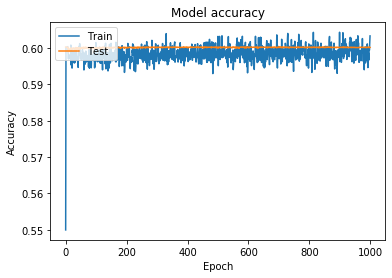

In [175]:

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

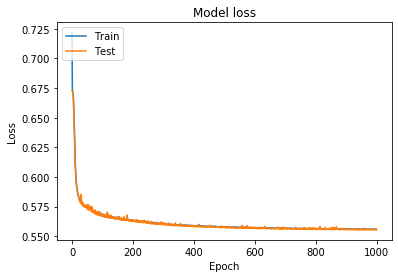

In [176]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()